## Lightwave Explorer Post Processing

In this jupyter notebook I will show one how to interact with data saved from the Lightwave explorer simulation software using the associated python module as well as a pythong module which I have developed to be an extension of the LWE module. The GitHub repository for the simulation software can be found [here](https://github.com/NickKarpowicz/LightwaveExplorer/tree/master).

In [1]:
import os
import sys
# Print current directory
print("Current working directory:", os.getcwd())
# Change to parent directory
parent_dir = os.path.dirname(os.getcwd())
os.chdir(parent_dir)
# Print new working directory
print("New working directory:", os.getcwd())
# Add the new directory to sys.path
sys.path.append(os.getcwd())
from lwe import LightwaveExplorer as lwe
import lwe_util.lwe_util as util
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

Current working directory: c:\Users\robert\Desktop\chini_lab_code\LWE_util\examples
New working directory: c:\Users\robert\Desktop\chini_lab_code\LWE_util


In [ ]:
# TODO: format the text on the graphs correctly (sorry im lazy)
def import_data(sim_object: lwe.lightwaveExplorerResult, 
                Ex: bool = True, 
                Ey: bool = True, 
                freq: bool = True, 
                spectrum_x: bool = True,
                spectrum_y: bool = True, 
                time: bool = True) -> list:
    
    # Check object type
    if not isinstance(sim_object, lwe.lightwaveExplorerResult):
        raise TypeError(f"import_data expected a LightwaveExplorer, "
                        f"got {type(sim_object).__name__!r}")
    
    data = {}
    if Ex:          data["Ex"] = sim_object.Ext_x
    if Ey:          data["Ey"] = sim_object.Ext_y
    if freq:        data["freq"] = sim_object.frequencyVectorSpectrum
    if spectrum_x:  data["spectrum_x"] = sim_object.spectrum_x
    if spectrum_y:  data["spectrum_y"] = sim_object.spectrum_y
    if time:        data["time"] = sim_object.timeVector
    return data


def radially_average(E_field: np.ndarray, radius: float, spatial_step: float, timeVector: list = []) -> tuple:
    """
        This function is made to radially average the E field data out to a certain radius. Lightwave explorer returns E field data in the form
    of a two dimensional array where each column represent the E field data across the entire time axis for some point on the transverse grid. 

    Args:
        E_field: This should be the 2D array containing the E field data of interest
        radius: The radius to average out to (must be smaller than transverse grid) (unit: m)
        spatial_step: the step size of the transverse grid (unit: m)
        timeVecotor: optional argument, pass if you want to graph the radially averaged field

    return:
        tuple: a tuple containing the radially averaged E field data and the enevlope of the pulse
    """

    # Determine whether grid has an even or odd amount of steps
    Nx = E_field.shape[1]

    if (Nx % 2) == 0:
        even_grid = True
    else:
        even_grid = False


    # Determine whether the radius is too large
    grid_size = Nx * spatial_step
    if radius >= grid_size:
        raise ValueError(f"radius is too large, grid size: {grid_size}, radius: {radius}")
    

    # Calculate amount of radial steps such that the averaging is symmetric and as close to the 
    # target radius as possible
    radial_steps = radius / spatial_step
    if even_grid:
        if (radial_steps % 2) == 0:
            pass

        if (radial_steps % 2) >= 1:
            mod = radial_steps % 2
            diff = 2 - mod
            radial_steps = radial_steps + diff

        if (radial_steps % 2) < 1:
            mod = radial_steps % 2
            radial_steps = radial_steps - mod
    else:
        if (radial_steps % 2) == 1:
            pass

        else:
            mod = radial_steps % 2
            radial_steps = radial_steps + 1 - mod


    # If rounding of radial steps increased the radius passed the grid size subtract 2 steps
    if (radial_steps * spatial_step) >= grid_size:
        radial_steps = radial_steps - 2

    
    # Determine which indices to average over
    if even_grid:
        i = (Nx / 2) - 1
        index1 = i - (radial_steps / 2 - 1)
        index2 = i + 1 + (radial_steps / 2 - 1)
    else:
        i = (Nx / 2) - 0.5
        index1 = i - ((radial_steps - 1) / 2)
        index2 = i + ((radial_steps - 1) / 2)

    
    # Compute radial average
    average = np.mean(E_field[:,int(index1):int(index2)+1], axis = 1) # last index exclusive
    envelope = np.abs(hilbert(average))

    if len(timeVector):
        plt.figure(figsize=(10, 5))
        plt.plot(timeVector * 1e15, average * 1e-9, label=r'Radially Averaged $E_{x}$')
        plt.plot(timeVector * 1e15, envelope * 1e-9, color='red', linestyle='--', label=r'Radially Averaged $E_{x}$ Envelope')
        plt.xlabel('Time (fs)')
        plt.ylabel(r'$E_{x}$ (GV/m)')
        plt.title(r'$E_{x}(t)$ with Envelope')
        plt.legend()
        plt.grid()
        plt.show()
        print(f"averaged symmetrically over {radial_steps * spatial_step} meters")

    return (average, envelope)

# TODO: Make this function work better off by like 2.5%
def calculate_pulse_energy(E_field: np.ndarray, dr: float, dt: float, rad: float = 0) -> float:
    """
    This function calculate the energy of a radially symmetric guassian pulse. The data that you pass to this function should be a matrix
    containing Ex(r,t) where each column is some radius and the center of the transverse grid is the middle index (LWE does this by default)
    
    Args:
        E_field: Matrix conatining E field data, each column is should be some r, the center of the transverse grid (origin) should be the
        center index.
        dr: transverse grid spatial step in meters
        dt: time step
        rad: radius to restrict integration to, does entire grid by default 
    """

    # Define relavant constants 
    epsilon0 = 8.854e-12    # F/m
    c = 3e8                 # m/s

    # Determine grid parameters
    Nt, Nx = E_field.shape
    if (Nx % 2) == 0:
        even_grid = True
    else:
        even_grid = False

    # Determine whether the radius is too large
    grid_size = Nx * dr
    if rad >= grid_size:
        raise ValueError(f"radius is too large, grid size: {grid_size}, radius: {rad}")


    # Compute pulse energies
    if not rad: 

        if even_grid:
            # Compute radial area weights
            Nr = int(Nx / 2)
            i = np.arange(1, Nr+1, 1)
            r = (i - 0.5) * dr
            dA = 2 * np.pi * r * dr

            # Compute intensity as a function of t
            E_radial = E_field[:, Nr:2*Nr]
            I_time = np.sum(np.abs(E_radial)**2 * dA[None, :], axis = 1)

        else:
            # Compute radial area weights
            Nr = int( (Nx/2) + 0.5)
            i = np.arange(1, Nr+1, 1)
            r = (i - 0.5) * dr
            dA = 2 * np.pi * r * dr
        
            # Compute intensity as a function of t
            E_radial = E_field[:, Nr-1:2*Nr-1]
            I_time = np.sum(np.abs(E_radial)**2 * dA[None, :], axis = 1)

        # sum over time
        pulse_energy = epsilon0 * c * np.trapezoid(I_time, dx=dt)
        
    else:
        # Calculate energy up to specified radius
        pulse_energy = 0

    
    return pulse_energy


def map_beam_radius(beam_waist: float, rayleigh_length: float, max_z: float, precision: float, verbose: bool = True) -> tuple:
    """
    Calculates the beam waist of the described guassian beam for some extent of z. returns a list of these
    values and has the option to plot the function.
    
    Args:
        beam_waist: guassian beam waist, most narrow radius of beam (m)
        rayleigh_length: desired rayleigh length of beam (m)
        max_z: extent to which one wants their array created to (m)
        precision: what spatial increment to compute the beam radius at, starts at 0 (m)
        verbose: whether to graph the results or not

    returns:
        tuple: A tuple containing the z_axis used for computation as well as the beam radius values
    
    """
    if not (max_z > precision):
        raise ValueError(f"Maximum Z value must be greater than the desired precision")
    
    z_axis = np.arange(0.0, max_z, precision)
    beam_radius = np.sqrt( beam_waist**2 * (1 + (z_axis / rayleigh_length)**2) )

    if verbose:
        plt.figure(figsize=(10,5))
        plt.plot(z_axis, beam_radius, label=r'Beam Radius')
        plt.xlabel("Z Position (m)")
        plt.ylabel("Beam Radius (m)")
        plt.title(" Beam Radius vs Z ")
        plt.grid()
        if max_z > rayleigh_length:
            plt.axvline(x=rayleigh_length, color='red', linestyle='--', label='$Z_{R}$')
        plt.legend()
        plt.show()

    return (z_axis, beam_radius)


def map_peak_intensity(beam_waist: float, rayleigh_length: float, max_z: float, precision: float,
                       pulse_duration: float, pulse_energy: float, verbose: bool = True) -> tuple:
    """
    Calculates the beam waist of the described guassian beam for some extent of z. Then uses the beam waist calculation to calculate the
    peak intensities along the propogation direction.
    
    Args:
        beam_waist: guassian beam waist, most narrow radius of beam (m)
        rayleigh_length: desired rayleigh length of beam (m)
        max_z: extent to which one wants their array created to (m)
        precision: what spatial increment to compute the beam radius at, starts at 0 (m)
        verbose: whether to graph the results or not

    returns:
        tuple: A tuple containing the z_axis used for computation as well as the peak intensities along this axis
    
    """

    beam_radius = map_beam_radius(beam_waist, rayleigh_length, max_z, precision, verbose=False)
    peak_intensities = (1.88 * pulse_energy) / (pulse_duration * np.pi * beam_radius[1]**2)

    if verbose:
        plt.figure(figsize=(10,5))
        plt.plot(beam_radius[0], peak_intensities * 1e-16, label=r'Peak Intensity')
        plt.xlabel("Z Position (m)")
        plt.ylabel("Peak Intensity (TW/cm^2)")
        plt.title("Peak Intensity vs Z")
        plt.grid()
        if max_z > rayleigh_length:
            plt.axvline(x=rayleigh_length, color='red', linestyle='--', label='$Z_{R}$')
        plt.legend()
        plt.show()

    return (beam_radius[0], peak_intensities)


def calculate_pulse_duration(E_field: np.ndarray, radius: float, spatial_step: float, timeVector: list, verbose: bool = False) -> float:
    """
    Calculates the pulse duration of some pulse using a radially averged E field.

    Args:
        E_field: Electrc field matrix each column is some transverse position, on axis field should be center index
        radius: radius to average out to (m)
        spatial_step: transverse grid step (m)
        timeVector: the time vector used in the simulation (s)
        verbose: optional argument, determines whether to graph the averaged E fields or not
    returns:
        pulse_duration: the FWHM of the averaged E fields temporal intensity distribution (s)
    
    """
    if verbose:
        E_avg = radially_average(E_field, radius, spatial_step, timeVector = timeVector)
    else:
        E_avg = radially_average(E_field, radius, spatial_step)

    pulse_duration = lwe.fwhm(timeVector, E_avg[1]**2)

    if verbose:
        plt.figure(figsize=(10, 5))
        plt.plot(timeVector * 1e15, (E_avg[0] * 1e-9)**2, label=r'$E_{avg}(t)^2$')
        plt.plot(timeVector * 1e15, (E_avg[1] * 1e-9)**2, label='Envelope', linestyle='--')
        peak_y = (E_avg[1] * 1e-9).max()**2
        plt.text(20, peak_y - (0.2 * peak_y), f'FWHM: {pulse_duration * 1e15:.2f} fs',
                fontsize=12, color='red',
                bbox=dict(facecolor='white', edgecolor='black', alpha=0.8))
        plt.xlabel('Time (fs)')
        plt.ylabel(r'$E_{avg}(t)^2$ $(GV^2/m^2)$')
        plt.title(r'$E_{avg}(t)^2$ with Envelope')
        plt.legend()
        plt.grid()
        plt.show()

    return pulse_duration


def calculate_beam_radius(E_field: np.ndarray, spatial_step: float, intensity_drop: float = 0.5) -> float:
    """
    Calculates the half intensity radius of an E_field matrix. The % of intensity drop off used for the radius calculation can be changed

    Args:
        E_field: E field matrix [time, x] (V/m)
        spatial_step: spatial step of transverse grid (m)
        intensity drop: decimal representing percent drop to be used for radius calculation
    
    returns:
        radius: beam radius at the desired intensity drop off
    """

    I = np.abs(E_field)**2
    t0, j0 = np.unravel_index(np.argmax(I), I.shape)
    I_prof = I[t0, :]
    I_half = 0.5 * I_prof.max()
    

### Attempting to Match Pulse Compression from Hemmer et al. to LWE Simulations

In this section I attempt to match recreate the experiment from Hemmer et al. with a focus on recreating the pulse compression plot below:

<div align="center">
  <img src="./figures/Hemmer_pulse_compression.png" alt="Alt text" width="400"/>
</div>

For this I created an input pulse in Lightwave explorer which matches the specified parameters of the input pulse used in the paper, I also used a 2 uJ seed pulse:
* $E_{pulse} = 3 uJ$
* $v_{0, pulse} = 96.71 THz$
* $\Delta t_{pulse} = 70 fs$
* $\Delta v_{pulse} = 5.354 THz$
* $\omega _{0} = 50 um$ (From confocal parameter b = 5mm)

For calculating the pulse duration the pulses are radially averaged over 52 um and then the FWHM of the intensity envelope is used as the pulse duration. The crystal parameters are listed below:
* NL absorption = 0.56e-19
* YAG Bandgap = 6.5 eV
* Drude model momentum relaxation rate = 50 THz
* Effecteve electron mass = 0.4

The grid parameters are:
* max x = 512 um, dx = 2 um
* max t = 307.2 fs, dt = 0.4 fs
* max z = 3000 um, dz = 500 nm

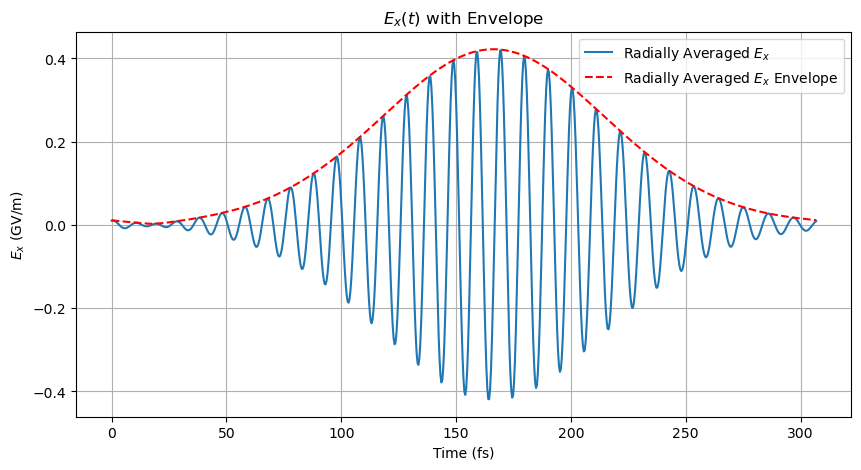

averaged symmetrically over 5.2e-05 meters


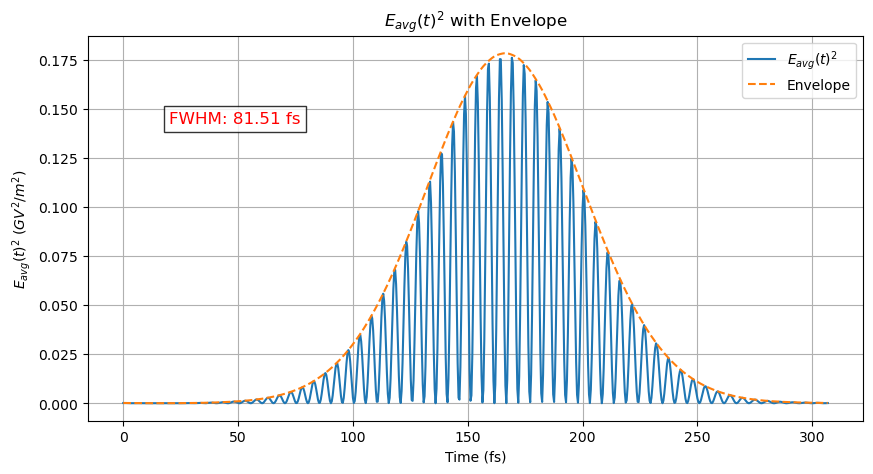

In [3]:
# PULSE DURATION CALCULATOR
###########################

# Import Data to read pulse duration 
path = "./test_data/Hemmer_sims_NL_1/3_uj/24mm.zip"
sim = lwe.load(path)
import_params = ["True", "False", "True", "True", "False", "True"]
data = util.import_data(sim, *import_params)
dx = sim.spatialStep
radius = 50e-06

# Calculate Pulse Duration
pulse_duration = util.calculate_pulse_duration(data["Ex"], radius, dx, data["time"], verbose = True)

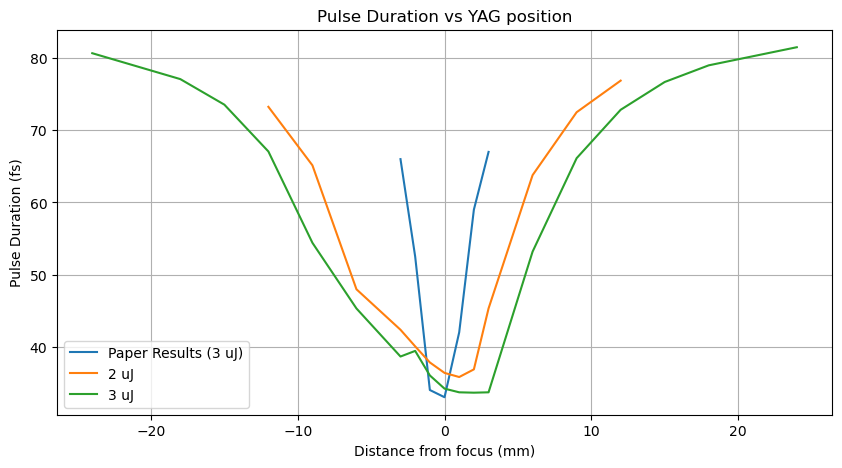

In [4]:
# PULSE DURATION COMPARISON FROM CALCULATED DATA
################################################

x_axis1 = [-12, -9, -6, -3, -2, -1, 0, 1, 2, 3, 6, 9, 12]
x_axis3 = [-24, -18, -15, -12, -9, -6, -3, -2, -1, 0, 1, 2, 3, 6, 9, 12, 15, 18, 24]
x_axis2 = [-3, -2, -1, 0, 1, 2, 3]
E0 = [66, 52.5, 34, 33, 42, 59, 67]
E1 = [73.25, 65.14, 47.96, 42.35, 40.05, 37.82, 36.37, 35.8, 36.86, 45.31, 63.78, 72.5, 76.88]
E2 = [80.68, 77.09, 73.55, 67.06, 54.4, 45.3, 38.64, 39.42, 36.02, 34.19, 33.68, 33.63, 33.680, 53.18, 66.13, 72.84, 76.69, 79, 81.51]
# E3 = [54.41, 51.23, 50.85, 53.48, 57.68, 62.1, 66.09]

plt.figure(figsize=(10, 5))
plt.plot(x_axis2, E0, label=r'Paper Results (3 uJ)')
# plt.plot(x_axis, E3, label=r'1 uJ')
plt.plot(x_axis1, E1, label=r'2 uJ')
plt.plot(x_axis3, E2, label=r'3 uJ')
plt.xlabel('Distance from focus (mm)')
plt.ylabel(r'Pulse Duration (fs)')
plt.title('Pulse Duration vs YAG position')
plt.legend()
plt.grid()
plt.show()

### Investigating and Comparing Simulated Energy Loss to Experimental Losses

In this section I compute the energies of both the input (seed) pulse and the output pulse to identify how much energy was lost during the pulses propogation through the medium. The goal with this work is to compare the simulated values to the plasma losses in the Hemmer et al. paper. The two pulses used are the same as described above, in fact the same data is used.

<div align="center">
  <img src="./figures/Hemmer_plasma_losses.png" alt="Alt text" width="400"/>
</div>

* $E_{pulse} = 3 uJ$
* $v_{0, pulse} = 96.71 THz$
* $\Delta t_{pulse} = 70 fs$
* $\Delta v_{pulse} = 5.354 THz$
* $\omega _{0} = 50 um$ (From confocal parameter b = 5mm)

In [5]:
# ENERGY LOSS CALCULATOR
########################

# Input Pulse
path1 = "./test_data/Hemmer_sims_NL_1/3_uj/seed.zip"
sim1 = lwe.load(path1)
data1 = util.import_data(sim1, *import_params)
dx1 = sim1.spatialStep
dt1 = sim1.timeStep
radius1 = 50e-06

print("# INPUT PULSE")
print("###############")

E_avg1 = util.radially_average(data1["Ex"], radius1, dx1)
pulse_duration1 = util.calculate_pulse_duration(data1["Ex"], radius1, dx, data1["time"], verbose = False)
pulse_energy1 = util.calculate_pulse_energy(data1["Ex"], dx1, dt1)

print(f"FWHM Pulse Duration of Input Pulse(fs): {pulse_duration1 * 1e15: .3f}")
print(f"Input Pulse Energy (uJ): {pulse_energy1 * 1e6: .3f}")


# Input Pulse
path2 = "./test_data/Hemmer_sims_NL_1/3_uj/-9mm.zip"
sim2 = lwe.load(path2)
data2 = util.import_data(sim2, *import_params)
dx2 = sim2.spatialStep
dt2 = sim2.timeStep

print("# OUTPUT PULSE")
print("###############")

E_avg2 = util.radially_average(data2["Ex"], radius1, dx2)
pulse_duration2 = util.calculate_pulse_duration(data2["Ex"], radius, dx2, data2["time"], verbose = False)
pulse_energy2 = util.calculate_pulse_energy(data2["Ex"], dx2, dt2)

print(f"FWHM Pulse Duration of Input Pulse(fs): {pulse_duration2 * 1e15: .3f}")
print(f"Input Pulse Energy (uJ): {pulse_energy2 * 1e6: .3f}")
print(f"Total energy loss (%): {100 * (1 - (pulse_energy2 / pulse_energy1)): .3f}")

# INPUT PULSE
###############
FWHM Pulse Duration of Input Pulse(fs):  70.040
Input Pulse Energy (uJ):  3.065
# OUTPUT PULSE
###############
FWHM Pulse Duration of Input Pulse(fs):  54.398
Input Pulse Energy (uJ):  3.051
Total energy loss (%):  0.457


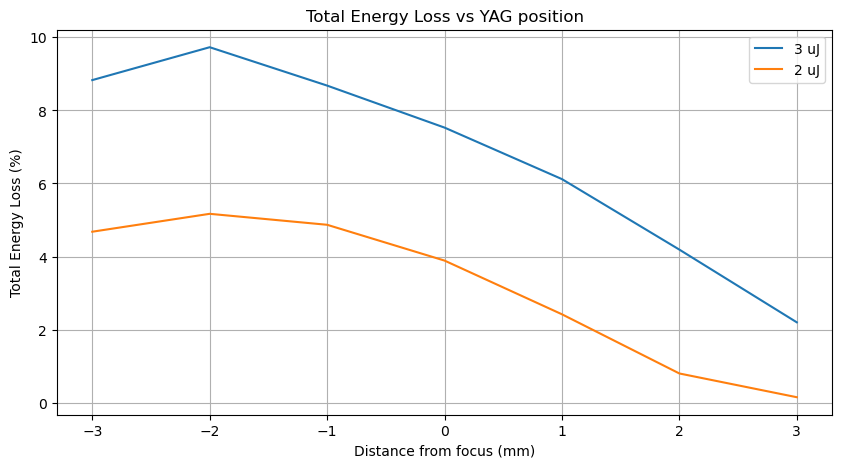

In [7]:
# ENERGY LOSS COMPARISON FROM CALCULATED DATA
################################################

x_axis = [-3, -2, -1, 0, 1, 2, 3]
losses1 = [8.83, 9.73, 8.68, 7.53, 6.12, 4.19, 2.2]
losses2 = [4.68, 5.17, 4.87, 3.89, 2.42, 0.8, 0.15]

plt.figure(figsize=(10, 5))
plt.plot(x_axis, losses1, label=r'3 uJ')
plt.plot(x_axis, losses2, label=r'2 uJ')
plt.xlabel('Distance from focus (mm)')
plt.ylabel(r'Total Energy Loss (%)')
plt.title('Total Energy Loss vs YAG position')
plt.legend()
plt.grid()
plt.show()


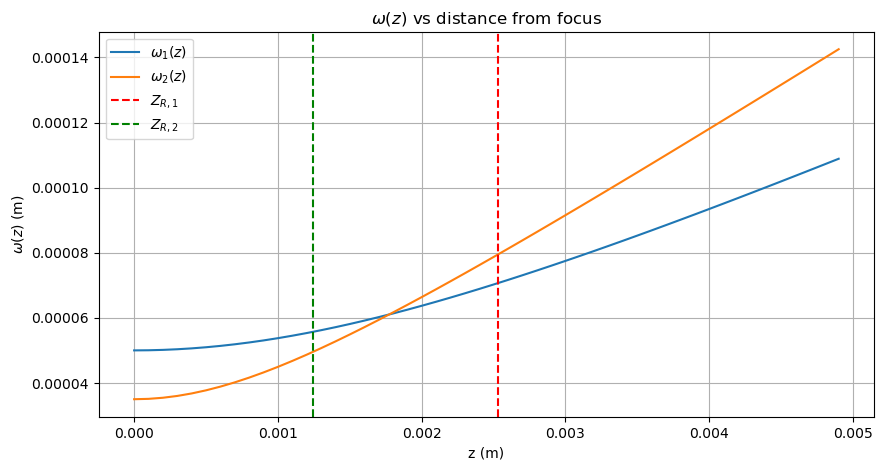

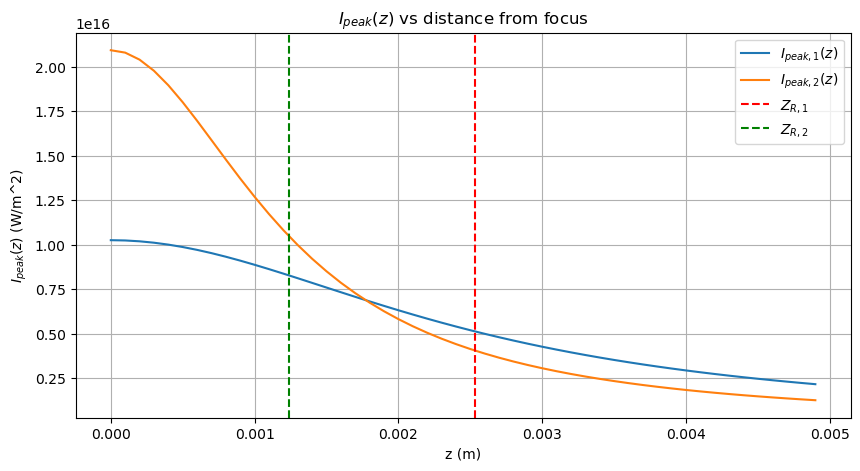

Target intensity values
[1.02586729 0.88758858 0.63201633 0.42706692]
z cordinate of matching intensity
[0.00126742 0.00144821 0.00188837 0.00245347]


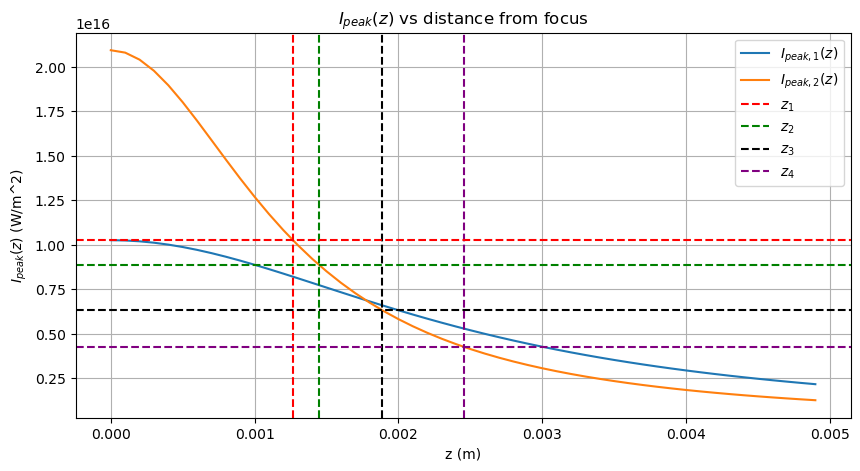

In [10]:
# Compare beam radii as a function of propogation distance from the focus
wavelength = 3100e-09 # m
Ep1 = 3e-06 # J
Ep2 = 3e-06 # J
w1 = 50e-06 # m
w2 = 35e-06 # m
Zr1 = (np.pi * w1**2) / wavelength # m
Zr2 = (np.pi * w2**2) / wavelength # m
pulse_duration = 70e-15 # s

beam_radius1 = util.map_beam_radius(w1, Zr1, 0.005, 0.0001, verbose=False)
beam_radius2 = util.map_beam_radius(w2, Zr2, 0.005, 0.0001, verbose=False)

plt.figure(figsize=(10,5))
plt.plot(beam_radius1[0], beam_radius1[1], label=r'$\omega _{1} (z)$')
plt.plot(beam_radius1[0], beam_radius2[1], label=r'$\omega _{2} (z)$')
plt.xlabel("z (m)")
plt.ylabel(f"$\omega (z)$ (m)")
plt.title(f"$\omega (z)$ vs distance from focus")
plt.grid()
plt.axvline(x=Zr1, color='red', linestyle='--', label='$Z_{R,1}$')
plt.axvline(x=Zr2, color='green', linestyle='--', label='$Z_{R,2}$')
plt.legend()
plt.show()


# Compare Peak intensities as a function of propogation distance from the focus
beam_intensities1 = util.map_peak_intensity(w1, Zr1, 0.005, 0.0001, pulse_duration, Ep1, verbose=False)
beam_intensities2 = util.map_peak_intensity(w2, Zr2, 0.005, 0.0001, pulse_duration, Ep2, verbose=False)

plt.figure(figsize=(10,5))
plt.plot(beam_intensities1[0], beam_intensities1[1], label=r'$I _{peak,1} (z)$')
plt.plot(beam_intensities1[0], beam_intensities2[1], label=r'$I _{peak,2} (z)$')
plt.xlabel("z (m)")
plt.ylabel(r"$I_{peak} (z)$ (W/m^2)")
plt.title(r"$I_{peak} (z)$ vs distance from focus")
plt.grid()
plt.axvline(x=Zr1, color='red', linestyle='--', label='$Z_{R,1}$')
plt.axvline(x=Zr2, color='green', linestyle='--', label='$Z_{R,2}$')
plt.legend()
plt.show()

# Find at what z-coordinate does the intensity of the lower energy beam match that of the higher energy beam at 0mm, 1mm, 2mm, 3mm
z1_cords = [0, 0.001, 0.002, 0.003]
z1_indices = [0, 10, 20, 30]
target_intensities = np.array([beam_intensities1[1][0], beam_intensities1[1][10], beam_intensities1[1][20], beam_intensities1[1][30]])
print("Target intensity values")
print(target_intensities * 1e-16)
z2_at_targets = np.interp(target_intensities, beam_intensities2[1][::-1], beam_intensities2[0][::-1])
print("z cordinate of matching intensity")
print(z2_at_targets)

# Re plot the intensity graph with vertical lines for visual verification
plt.figure(figsize=(10,5))
plt.plot(beam_intensities1[0], beam_intensities1[1], label=r'$I _{peak,1} (z)$')
plt.plot(beam_intensities1[0], beam_intensities2[1], label=r'$I _{peak,2} (z)$')
plt.xlabel("z (m)")
plt.ylabel(r"$I_{peak} (z)$ (W/m^2)")
plt.title(r"$I_{peak} (z)$ vs distance from focus")
plt.grid()

plt.axvline(x=z2_at_targets[0], color='red', linestyle='--', label='$z_{1}$')
plt.axvline(x=z2_at_targets[1], color='green', linestyle='--', label='$z_{2}$')
plt.axvline(x=z2_at_targets[2], color='black', linestyle='--', label='$z_{3}$')
plt.axvline(x=z2_at_targets[3], color='purple', linestyle='--', label='$z_{4}$')

plt.axhline(y=target_intensities[0], color='red', linestyle='--')
plt.axhline(y=target_intensities[1], color='green', linestyle='--')
plt.axhline(y=target_intensities[2], color='black', linestyle='--')
plt.axhline(y=target_intensities[3], color='purple', linestyle='--')

plt.legend()
plt.show()
